### Importing Packages

In [583]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import random

In [601]:
#data = np.loadtxt('/Users/elleemortensen/Documents/GitHub/BP24/Ellee/Data/gaussian_large_d_1.tex')
data = np.loadtxt('/Users/elleemortensen/Documents/GitHub/BP24/Ellee/Data/gaussian_small_d_1.tex')
#data = np.loadtxt('/Users/elleemortensen/Documents/GitHub/BP24/Ellee/uniform_large_d_1.tex')
#data = np.loadtxt('/Users/elleemortensen/Documents/GitHub/BP24/Ellee/uniform_small_d_1.tex')
#df = pd.read_excel('/Users/elleemortensen/Downloads/D3Softball.xlsx', index_col=[0])
#df.replace('---', np.nan, inplace=True)
#df.dropna(inplace=True)
array = np.array(data)
df = pd.DataFrame(array)

In [ ]:
# for i in range(25):
#     df.iloc[:,i] = df.iloc[:,i].round()
#     df.iloc[:,i] = df.iloc[:,i].astype(int)
#     df.iloc[:,i] = df.iloc[:,i].astype("category")
# df.iloc[:,150] = df.iloc[:,150].astype("category")

### Splitting Data

In [ ]:
# split the dataset into training and testing data
# test_size: this is the percentage of data used for testing (20% in this case), so the rest is used for training data (80% in this case)
# random_state: this is a random number chosen that should be used each time to ensure we get the same data split each time
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size = 0.2, random_state = 52)

### XGBoost

In [ ]:
columns_to_convert = [
    'G', 'AB', 'H (Offensive)', 'H/G', 'BA', '2B (Offensive)', '2B/G',
    '3B (Offensive)', '3B/G', 'Innings Pitched', 'K (Def)', 'K/G (Def)',
    'BB Allowed', 'BB/G (Def)', 'K/BB', 'HA', 'HA/G', 'Runs Allowed',
    'Runs Allowed/G', 'ER Allowed', 'ERA', 'WHIP', 'PO', 'A', 'E', 'E/G',
    'FPCT', 'HBP (Offensive)', 'HBP/G', 'BB (Offensive)', 'BB/G (Off)',
    'SF (Offensive)', 'SH (Offensive)', 'OBP', 'SHO', 'SHO %', 'SB',
    'SB/G', 'TB', 'TB/G', 'SLG PCT', 'R', 'R/G', 'DP', 'DP/G',
    'K (Off)', 'K/G (Off)'
]

# Convert the columns to float
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# create model instance
# n_estimators: number of trees(estimators) the model uses --> the more used, the more accurate the model is
# max_depth: maximum depth of tree --> higher number makes model more complex, but too high can cause overfitting
# learning_rate: quantifies each tree's contribution to total prediction --> lower number takes longer, but can lead to better generalization
# objective: binary:logistic outputs probabilities. if classification is wanted, use binary:hinge
# bst = XGBClassifier(n_estimators = 2, max_depth = 2, learning_rate = 1, objective = 'binary:logistic', enable_categorical = True)

# # fit model with the training data
# bst.fit(X_train, y_train)

# # make predictions for the test dataset
# preds = bst.predict(X_test)

# # print predictions
# print(preds)

# # print model Accuracy (how often the classifier is correct)
# print("Accuracy:", metrics.accuracy_score(y_test, preds))

# Create XGBoost model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical=True)

# Fit model with the training data
bst.fit(X_train, y_train)

# Make predictions for the test dataset
preds = bst.predict(X_test)

# Print predictions
print("Predictions:", preds)

# Calculate and print F1 score
f1 = metrics.f1_score(y_test, preds)
print("F1 Score:", f1)

### FIC

In [ ]:
class FeatureClassifier:
  def __init__(self,reqAcc = 0.01, classifier = 'DecisionTree', bias = [], control = None, n_jobs = None, random_state = None):
    self.featureClassifiers=[] #list of all the classifiers of all the selected features
    self.reqAcc=reqAcc #user specified cutoff value
    self.indexLs=[] # list of mapped index values to featureClassifiers
    self.flag=0
    self.bias=bias # list of biases for each and every label
    self.control=control #overfitting control for decision trees
    self.classifier=classifier #the classifier which is preferred by the user
    self.dic={'DecisionTree':0,'LinearRegression':1,'SVM':2,'LogisticRegression':3} #a dictionary which maps the classifier to its index
    self.n_jobs=n_jobs
    self.random_state=random_state
    self.num_lables = None

  def finIndex(self):
    #finds the index where the reqAcc condition fails and also created the indexLs[] for mapping
    for i in range(len(self.featureClassifiers)):
      if self.featureClassifiers[i][1] < self.reqAcc:
        return i
      self.indexLs.append(self.featureClassifiers[i][2])
    self.flag=1
    return i

  def fit(self,x,y):
    #applied the model to the dataset. The model is trained and saved for further prediction
    self.num_lables=len(set(y.flatten()))
    bestfeatures = SelectKBest(score_func=chi2,k=1)
    fit = bestfeatures.fit(x,y)

    for i in range(len(x[0])):
      clf=[DecisionTreeClassifier(max_depth=self.control,random_state=self.random_state),LinearRegression(n_jobs=self.n_jobs),SVC(gamma=self.control,random_state=self.random_state), LogisticRegression(penalty=self.control,random_state=self.random_state)][self.dic[self.classifier]]
      X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=self.random_state)
      clf.fit(X_train[:,i:i+1],y_train)
      self.featureClassifiers.append((clf,fit.scores_[i],i))
    self.featureClassifiers.sort(key=lambda x:x[1],reverse=True)
    index=self.finIndex()
    if self.flag==0:
      self.featureClassifiers=self.featureClassifiers[:index]
    return

  def predict(self,x):
    #given a list of inputs, predicts the possible outputs
    if not self.bias:
      self.bias=np.zeros(self.num_lables)
    if len(self.bias)<self.num_lables:
      raise AttributeError('Please check the lenth of bias list')
    yPred=[]
    for i in range(len(x)):
      pred_arr=np.zeros(self.num_lables)
      for j in range(len(self.indexLs)):
        pred=np.round(self.featureClassifiers[j][0].predict([[x[i][self.indexLs[j]]]]))
        pred_arr[pred]+=self.featureClassifiers[j][1]+self.bias[pred[0]]
      yPred.append(np.argmax(pred_arr))
    return yPred

In [ ]:
#train the model using the training sets
clf1=FeatureClassifier(0,classifier='DecisionTree',control=3)
# clf1.fit(X_train,y_train.reshape(-1,1))
clf1.fit(np.array(X_train), np.array(y_train)[:,np.newaxis].astype(int))

#predict the response for the test dataset
#model accuracy (how often the classifier is correct)
print("Accuracy:", metrics.accuracy_score(np.array(y_test).astype(int),clf1.predict(np.array(X_test))))

print(clf1.indexLs)
clf1.featureClassifiers
print(clf1.indexLs)

In [ ]:
# Assuming FeatureClassifier is correctly implemented for DecisionTreeClassifier
clf1 = FeatureClassifier(0, classifier='DecisionTree', control=3)

# Fit model with the training data
clf1.fit(np.array(X_train), np.array(y_train).astype(int))

# Predict the response for the test dataset
y_pred = clf1.predict(np.array(X_test))

# Calculate and print F1 score
f1 = metrics.f1_score(np.array(y_test).astype(int), y_pred)
print("F1 Score:", f1)

# Print other relevant outputs for debugging
print(clf1.indexLs)

### KNN

In [ ]:
#create a knn classifier
#n_neighbors: predicting the label of the data point by looking at the 3 closest data points and getting them to "vote"
#algorithm: we may need to look at this if it misbehaves
neigh = KNeighborsClassifier(n_neighbors=5)

#train the model using the training sets
neigh.fit(X_train, y_train)

#predict the response for the test dataset
y_pred = neigh.predict(X_test)

#print predictions
print(y_pred)

#model accuracy (how often the classifier is correct)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

In [ ]:
# Create KNN classifier instance
neigh = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
neigh.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = neigh.predict(X_test)

# Print predictions
print("Predictions:", y_pred)

# Calculate and print F1 score
f1 = metrics.f1_score(y_test, y_pred)
print("F1 Score:", f1)

### SVM

#### SVM Accuracy

In [ ]:
#Create a svm Classifier
# kernel: options for kernel include linear, poly, rbf, sigmoid
    # linear: use this when data can be split by a linear function
    # poly (polynomial): use this when data can be split by a polynomial function
    # rbf (radial basis function): use this when there are clusters of one class inside another
    # sigmoid: use this when the split between classes is curved and irregular
clf = svm.SVC(kernel='linear')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# print predictions
print("Predictions:", y_pred)

# print model Accuracy (how often the classifier is correct)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

#### SVM F1 Scores

In [ ]:
# Create SVM classifier instance with linear kernel
clf = svm.SVC(kernel='linear')

# Train the model using the training sets
clf.fit(X_train.iloc[:,0:25], y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test.iloc[:,0:25])

# Print predictions
print("Predictions:", y_pred)

# Calculate F1 score
print("F1 Score:", metrics.f1_score(y_test, y_pred))

#### SVM Experimentation

In [430]:
# Initialize an empty list to store F1 scores
f1_scores = []

# Loop over dimensions from 1 to 25
for i in range(1, 26):
    # Train the model using the training sets for the first i dimensions
    clf.fit(X_train.iloc[:, 0:i], y_train)
    
    # Predict the response for the test dataset
    y_pred = clf.predict(X_test.iloc[:, 0:i])
    
    # Calculate the F1 score and append it to the list
    f1 = metrics.f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Print F1 scores for each dimension
for i, score in enumerate(f1_scores, 1):
    print(f"F1 Score for {i} dimensions: {score}")

F1 Score for 1 dimensions: 0.7058823529411765
F1 Score for 2 dimensions: 0.5714285714285714
F1 Score for 3 dimensions: 0.75
F1 Score for 4 dimensions: 0.75
F1 Score for 5 dimensions: 0.7142857142857143
F1 Score for 6 dimensions: 0.8750000000000001
F1 Score for 7 dimensions: 0.8750000000000001
F1 Score for 8 dimensions: 0.8750000000000001
F1 Score for 9 dimensions: 0.9411764705882353
F1 Score for 10 dimensions: 1.0
F1 Score for 11 dimensions: 0.9411764705882353
F1 Score for 12 dimensions: 1.0
F1 Score for 13 dimensions: 1.0
F1 Score for 14 dimensions: 0.9411764705882353
F1 Score for 15 dimensions: 0.9411764705882353
F1 Score for 16 dimensions: 0.9411764705882353
F1 Score for 17 dimensions: 0.9411764705882353
F1 Score for 18 dimensions: 0.9411764705882353
F1 Score for 19 dimensions: 0.9411764705882353
F1 Score for 20 dimensions: 0.9411764705882353
F1 Score for 21 dimensions: 0.9411764705882353
F1 Score for 22 dimensions: 0.9411764705882353
F1 Score for 23 dimensions: 0.9411764705882353
F

In [605]:
# Set a seed for reproducibility
np.random.seed(42)

# Identify the target column in the dataframe
totalrows = df.shape[0]
totalcolumns = 35

# Sample 500 rows from the DataFrame for consistent labels
testing_indices = np.random.permutation(totalrows) - 1
sampled_df = df.iloc[testing_indices, :]

# Initialize an empty list to store F1 scores
f1_scores = []

# Initialize the SVM classifier with a linear kernel
clf = svm.SVC(kernel='linear')

# Maximum iterations allowed for sampling and evaluation
max_iterations = 100

# Initialize an array to store all F1 scores across iterations and samples
allf1scores = np.zeros((totalcolumns, max_iterations))

# Iterate over different numbers of sampled columns
for i in range(5,totalcolumns):
    iterations = 0
    # Sample the first 10*(i+1) rows for each iteration
    sampled_rows = sampled_df.iloc[0:10 * (i + 1), :]
    while iterations < max_iterations:
        # Randomly sample (i+1) columns from the first 10*(i+1) rows (excluding the target column)
        sampled_columns = sampled_rows.drop(columns=[totalcolumns-1]).sample(n=i+1, axis='columns').columns
            
        # Split the dataset into training and testing sets using the sampled indices
        X_train = sampled_rows[sampled_columns]
        y_train = sampled_rows.iloc[:, -1]
        # test_index = 10 * (i + 1) + np.ceil(((i+1)/0.7)*0.3).astype(int)
        test_index = np.ceil((10 * (i+1)) / 0.7).astype(int)
        X_test = sampled_df.iloc[10 * (i + 1):test_index, sampled_columns]
        y_test = sampled_df.iloc[10 * (i + 1):test_index, -1]
        # print(X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]))
        
        # Train the SVM classifier using the training sets for the sampled columns
        clf.fit(X_train, y_train)
        
        # Predict the response for the test dataset
        y_pred = clf.predict(X_test)
        
        # Calculate the F1 score and store it in the allf1scores matrix
        f1 = metrics.f1_score(y_test, y_pred)
        allf1scores[i, iterations] = f1

        if i == 11 and iterations == 30:
            saved_X_train = X_train.copy()
            saved_y_train = y_train.copy()
            saved_X_test = X_test.copy()
            saved_y_test = y_test.copy()
        
        # Increment the iterations counter
        iterations += 1

In [607]:
# Select 4 random columns
print(saved_X_train.info())
random_columns = random.sample(list(saved_X_train.columns), 4)
print("Randomly selected columns:", random_columns)
cat_X_train = saved_X_train.copy()

# Process the randomly selected columns
for col in random_columns:
    cat_X_train[col] = saved_X_train[col].round().astype(int).astype("category")
    
print(cat_X_train.dtypes)

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 360 to 41
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   112     120 non-null    float64
 1   55      120 non-null    float64
 2   139     120 non-null    float64
 3   101     120 non-null    float64
 4   63      120 non-null    float64
 5   17      120 non-null    float64
 6   129     120 non-null    float64
 7   125     120 non-null    float64
 8   73      120 non-null    float64
 9   8       120 non-null    float64
 10  80      120 non-null    float64
 11  31      120 non-null    float64
dtypes: float64(12)
memory usage: 12.2 KB
None
Randomly selected columns: [139, 8, 31, 112]
112    category
55      float64
139    category
101     float64
63      float64
17      float64
129     float64
125     float64
73      float64
8      category
80      float64
31     category
dtype: object


In [609]:
cat_X_test = saved_X_test.copy()

# Process the randomly selected columns
for col in random_columns:
    cat_X_test[col] = saved_X_test[col].round().astype(int).astype("category")
    
print(cat_X_test.dtypes)

112    category
55      float64
139    category
101     float64
63      float64
17      float64
129     float64
125     float64
73      float64
8      category
80      float64
31     category
dtype: object


In [613]:
clf.fit(cat_X_train, saved_y_train)
y_pred = clf.predict(cat_X_test)
f1 = metrics.f1_score(saved_y_test, y_pred)
print(f1)
print(cat_X_test.shape)
print(cat_X_train.shape)

0.8076923076923077
(52, 12)
(120, 12)


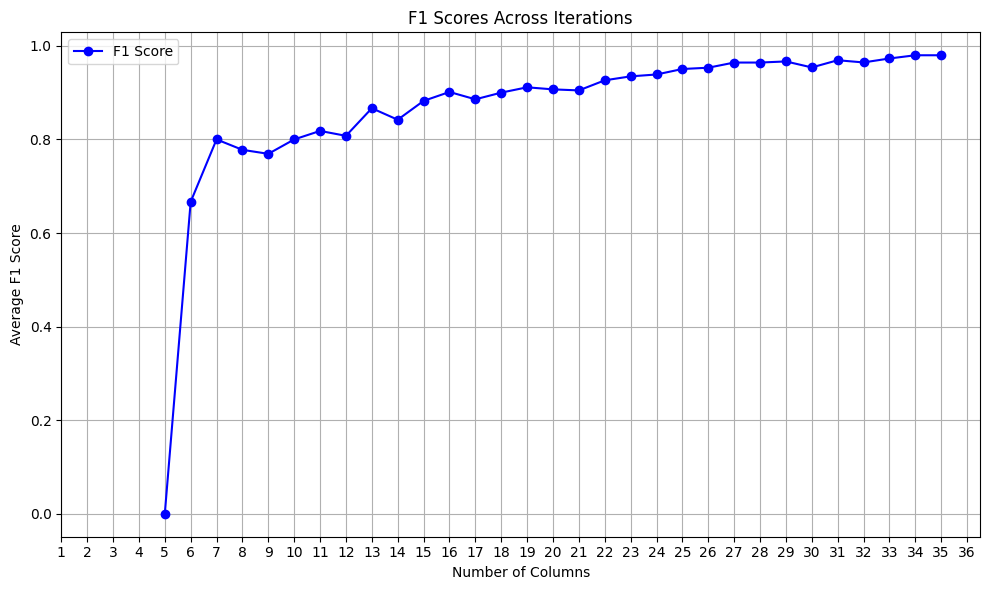

In [518]:
# Plotting the F1 scores across iterations
plt.figure(figsize=(10, 6))
plt.plot(range(5, totalcolumns+1), np.min(allf1scores[4:,:], axis=1), marker='o', linestyle='-', color='b', label='F1 Score')
plt.title('F1 Scores Across Iterations')
plt.xlabel('Number of Columns')
plt.ylabel('Average F1 Score')
plt.xticks(range(1, 37))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()